## Задание 4

Implement [Hierarchical Bayesian Domain Adaptation](https://aclanthology.org/N09-1068.pdf) for synthetic dataset.  
Model: linear regression.  
Compare the approach with baselines: one model per one domain, one model per all domains.  
Goal: is to make a very simple illustrative example, so try to focus on the illustrations

## Импорты

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle, Circle, Ellipse, Polygon
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time
import math

SEED = 100
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (14, 8)

## Подготовка данных

Данные -- изображения геометрических фигур: прямоугольник, круг, треугольник

Домены -- маленькие фигуры и большие фигуры (задаём с помощью параметров `max_size, min_size` функции `random_shapes`)

Image shape: (128, 128)
Labels: [('rectangle', ((68, 111), (66, 126)))]


Text(0.5, 1.0, 'Grayscale shape')

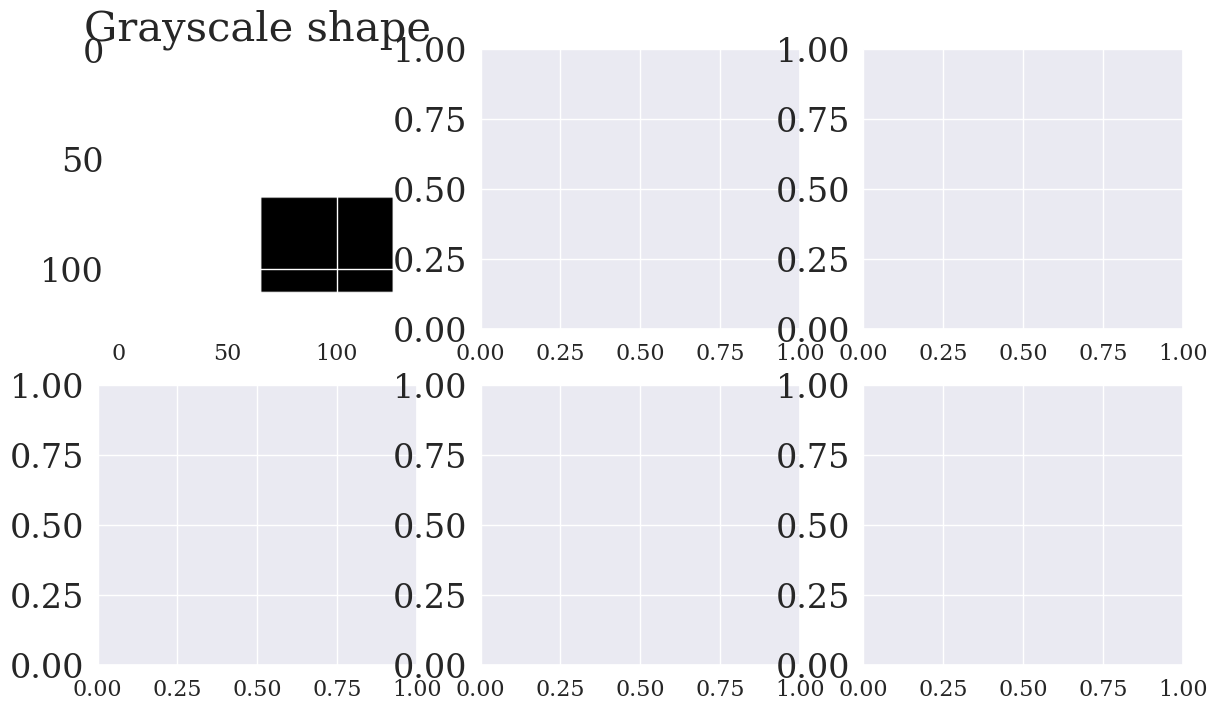

In [2]:
import matplotlib.pyplot as plt

from skimage.draw import random_shapes

# Let's start simple and generate a 128x128 image
# with a single grayscale rectangle.
result = random_shapes(
    (128, 128), min_size=40, max_shapes=1, shape='rectangle', channel_axis=None, rng=None
)

# We get back a tuple consisting of (1) the image with the generated shapes
# and (2) a list of label tuples with the kind of shape (e.g. circle,
# rectangle) and ((r0, r1), (c0, c1)) coordinates.
image, labels = result
print(f'Image shape: {image.shape}\nLabels: {labels}')

# We can visualize the images.
fig, axes = plt.subplots(nrows=2, ncols=3)
ax = axes.ravel()
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Grayscale shape')

In [3]:
SHAPE = (64, 64)
SIZE_THR = 24
K_FIGURES = 2000

small_rectangles = [random_shapes(SHAPE, max_size=SIZE_THR, max_shapes=1, shape='rectangle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]
small_circles = [random_shapes(SHAPE, max_size=SIZE_THR, max_shapes=1, shape='circle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]
small_triangles = [random_shapes(SHAPE, max_size=SIZE_THR, max_shapes=1, shape='triangle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]

large_rectangles = [random_shapes(SHAPE, min_size=SIZE_THR, max_shapes=1, shape='rectangle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]
large_circles = [random_shapes(SHAPE, min_size=SIZE_THR, max_shapes=1, shape='circle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]
large_triangles = [random_shapes(SHAPE, min_size=SIZE_THR, max_shapes=1, shape='triangle', channel_axis=None, rng=None) for _ in range(K_FIGURES)]

In [4]:
small_rectangles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in small_rectangles]
small_circles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in small_circles]
small_triangles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in small_triangles]

large_rectangles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in large_rectangles]
large_circles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in large_circles]
large_triangles_v2 = [x[0].astype(np.float32) / 255.0 + np.random.randn(*SHAPE) * 0.1 for x in large_triangles]

Иллюстрация данных

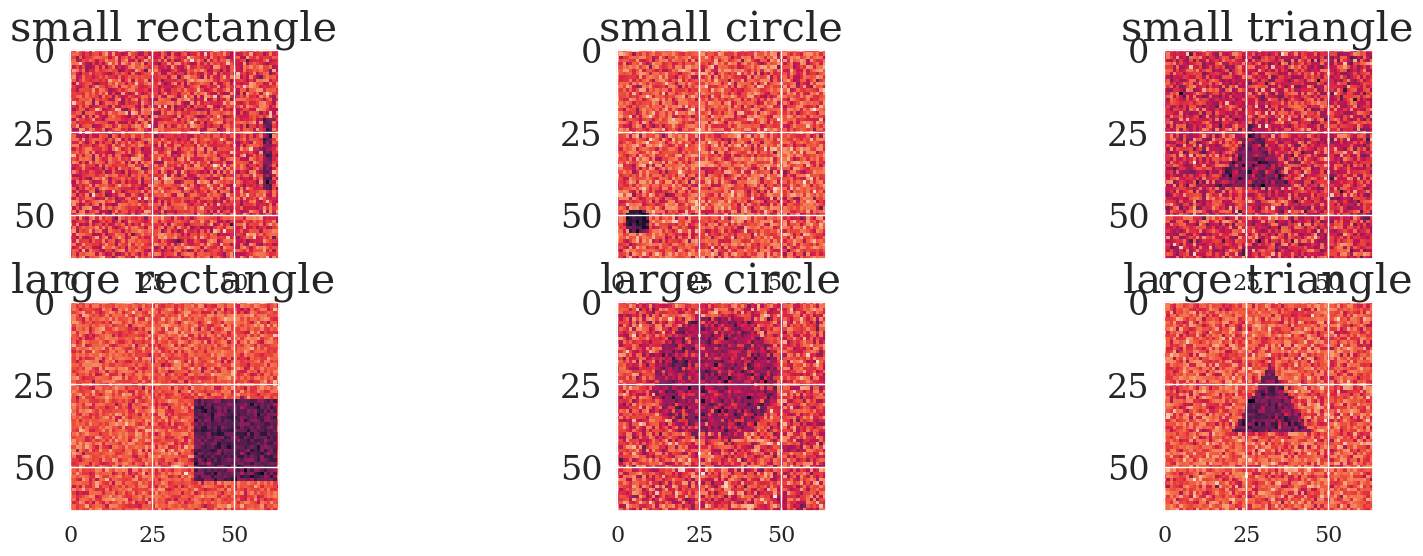

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 6))

axes[0, 0].imshow(small_rectangles_v2[0])
axes[0, 0].set_title('small rectangle')

axes[0, 1].imshow(small_circles_v2[0])
axes[0, 1].set_title('small circle')

axes[0, 2].imshow(small_triangles_v2[0])
axes[0, 2].set_title('small triangle')

axes[1, 0].imshow(large_rectangles_v2[0])
axes[1, 0].set_title('large rectangle')

axes[1, 1].imshow(large_circles_v2[0])
axes[1, 1].set_title('large circle')

axes[1, 2].imshow(large_triangles_v2[0])
axes[1, 2].set_title('large triangle')

plt.show()

In [6]:
# Rectangles = 0, Circles = 1, Triangles = 2

X_small = np.vstack((small_rectangles_v2, small_circles_v2, small_triangles_v2))
Y_small = np.array([0]*K_FIGURES + [1]*K_FIGURES + [2]*K_FIGURES)

X_large = np.vstack((large_rectangles_v2, large_circles_v2, large_triangles_v2))
Y_large = np.array([0]*K_FIGURES + [1]*K_FIGURES + [2]*K_FIGURES)

Нормализуем данные для дальнейшей подаче модели 

In [7]:
SMALL_MEAN = X_small.mean()
SMALL_STD = X_small.std()
LARGE_MEAN = X_large.mean()
LARGE_STD = X_large.std()

UNITED_MEAN = np.vstack((X_small, X_large)).mean()
UNITED_STD = np.vstack((X_small, X_large)).std()

In [8]:
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_small_tr, X_small_tst, Y_small_tr, Y_small_tst = train_test_split(X_small, Y_small, test_size=1 - train_ratio)
X_small_val, X_small_tst, Y_small_val, Y_small_tst = train_test_split(X_small_tst, Y_small_tst, test_size=test_ratio/(test_ratio + validation_ratio)) 

X_large_tr, X_large_tst, Y_large_tr, Y_large_tst = train_test_split(X_large, Y_large, test_size=1 - train_ratio)
X_large_val, X_large_tst, Y_large_val, Y_large_tst = train_test_split(X_large_tst, Y_large_tst, test_size=test_ratio/(test_ratio + validation_ratio)) 

Создаём Dataset и DataLoader

In [9]:
class FiguresDataset(Dataset):
    def __init__(self, seed, k_domains, device='cpu', mean=0.0, std=1.0, *data):
        super().__init__()
        self.k_domains = k_domains
        X_domains = []
        Y_domains = []
        domains = []
        
        assert len(data) % 2 == 0
        
        for i, val in enumerate(data):
            if i % 2 == 0:
                X_domains.append(val)
                domains.append(np.full(len(val), 1 + i // 2))
            else:
                Y_domains.append(val)
            
        
        X_domains_united = np.vstack(X_domains)
        Y_domains_united = np.hstack(Y_domains)
        domains_united = np.hstack(domains)
        
        np.random.seed(seed)
        permutation = np.random.permutation(len(X_domains_united))
        
        X_data = torch.tensor(X_domains_united[permutation]).float().to(device)
        
        self.X_data = (X_data - mean) / std
        self.Y_data = torch.tensor(Y_domains_united[permutation]).long().to(device)
        self.domain_data = torch.tensor(domains_united[permutation]).long().to(device)
    
    def __getitem__(self, ind):
        return self.domain_data[ind], self.X_data[ind], self.Y_data[ind]
    
    def __len__(self):
        return len(self.X_data)

In [36]:
BATCH_SIZE = 100

train_dataset = FiguresDataset(SEED, 2, DEVICE, UNITED_MEAN, UNITED_STD, X_small_tr, Y_small_tr, X_large_tr, Y_large_tr)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

val_dataset = FiguresDataset(SEED, 2, DEVICE, UNITED_MEAN, UNITED_STD, X_small_val, Y_small_val, X_large_val, Y_large_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_dataset = FiguresDataset(SEED, 2, DEVICE, UNITED_MEAN, UNITED_STD, X_small_tst, Y_small_tst, X_large_tst, Y_large_tst)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

## Одна модель на все домены

Базовая модель -- двуслойный перцептрон, класс `MLPBase`

In [11]:
class MLPBase(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(64*64, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.model(x.flatten(1))

$$\mathcal{L}_{\text{hier}} (\mathcal{D}; \theta) = \sum_d \left( \mathcal{L}_{\text{orig}} (\mathcal{D}_d; \theta_d) - \sum_i \frac{(\theta_{d,i} - \theta_{*,i})^2}{2\sigma^2_d} \right) - \sum_i \frac{\theta_{*,i}^2}{2\sigma^2_*}$$

- $\mathcal{L}_{\text{orig}}$ -- это минус кросс-энтропия
- $\sigma$ своя для каждого слоя, а именно $\sigma_{\text{layer}} = \sigma / (d_{in} + d_{out})$, где $d_{in}$ и $d_{out}$ -- размерности матрицы весов линейного слоя (для bias берётся только одна размерность)
- $\sigma_* = 1.0, \sigma_d = 0.1$
- вычитаемое из этой формулы реализовано в методе `calc_loss_regularizer`

Описание кода:
- создаём 3 копии `MLPBase` -- одну общую и две под каждый домен
- далее проводим инициализацию весов, как указано в статье: для общей модели -- $\mathcal{N}(0, \sigma_*^2)$, для доменных моделей -- $\mathcal{N}(\widehat{\theta_*^2}, \sigma_d^2)$
- forward-pass будет выглядеть так: в зав-ти от домена данных будет применяться соответствующая модель
- при этом в явном виде общая модель не участвует в инференсе модели
- но, так как её веса зашиты в функцию правдоподобия модели, то её веса будут меняться в процессе обучения

In [12]:
def split_domains(domain, x):
    domain_splits = {}
    
    unique_domains = torch.unique(domain)
    
    for d in unique_domains:
        domain_splits[int(d.item())] = x[domain == d]
    
    return domain_splits


class DomainAdaptiveMLP(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        self.sigmas = {
            'shared': nn.Parameter(torch.ones(1), requires_grad=False).to(device),
            'domain_1': nn.Parameter(0.1*torch.ones(1), requires_grad=False).to(device),
            'domain_2': nn.Parameter(0.1*torch.ones(1), requires_grad=False).to(device)
        }

        self.my_modules = nn.ModuleDict({
            'shared': MLPBase().to(device),
            'domain_1': MLPBase().to(device),
            'domain_2': MLPBase().to(device)
        })
        
        self.k_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        self._init()
    
    def _init(self):
        shared_sampled = []
        
        for param in self.my_modules['shared'].parameters():
            init_value = torch.randn_like(param, device=param.device) * self.sigmas['shared'] / torch.tensor(param.shape, device=param.device).sum().sqrt()
            init_value = init_value.float()
            param.data.copy_(init_value)
            shared_sampled.append(init_value)
        
        for i, param in enumerate(self.my_modules['domain_1'].parameters()):
            init_value = shared_sampled[i] + torch.randn_like(param, device=param.device) * self.sigmas['domain_1'] / torch.tensor(param.shape, device=param.device).sum().sqrt()
            init_value = init_value.float()
            param.data.copy_(shared_sampled[i])
        
        for i, param in enumerate(self.my_modules['domain_2'].parameters()):
            init_value = shared_sampled[i] + torch.randn_like(param, device=param.device) * self.sigmas['domain_2'] / torch.tensor(param.shape, device=param.device).sum().sqrt()
            init_value = init_value.float()
            param.data.copy_(shared_sampled[i])

    def forward(self, domain, x):
        output_splits = {}
    
        unique_domains = torch.unique(domain)

        for d in unique_domains:
            output_splits[int(d.item())] = self.my_modules[f'domain_{int(d.item())}'](x[domain == d])
            
        return output_splits
    
    def calc_loss_regularizer(self):
        reg_0 = 0
        for param in self.my_modules['shared'].parameters():
            reg_0 -= torch.sum(torch.square(param / self.sigmas['shared'] * torch.tensor(param.shape, device=param.device).sum().sqrt())) / 2
        
        reg_1 = 0
        for param_d, param in zip(self.my_modules['domain_1'].parameters(), self.my_modules['shared'].parameters()):
            reg_1 -= torch.sum(torch.square((param_d - param) / self.sigmas['domain_1'] * torch.tensor(param.shape, device=param.device).sum().sqrt())) / 2
            
        reg_2 = 0
        for param_d, param in zip(self.my_modules['domain_2'].parameters(), self.my_modules['shared'].parameters()):
            reg_2 -= torch.sum(torch.square((param_d - param) / self.sigmas['domain_2'] * torch.tensor(param.shape, device=param.device).sum().sqrt())) / 2
        
        return (reg_0 + reg_1 + reg_2) / self.k_params

In [13]:
def train(model, iterator, optimizer, criterion, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        domain, inp, trg = batch
        optimizer.zero_grad()

        output_splitted = model(domain, inp)
        trg_splitted = split_domains(domain, trg)
        
        loss_regularizer = model.calc_loss_regularizer()
        loss = loss_regularizer
        
        for d in output_splitted:
            # Берём лосс с минусом, т.к. хотим максимизировать правдоподобие, т.е. лосс = правдоподобие
            loss = loss - criterion(output_splitted[d], trg_splitted[d])
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            domain, inp, trg = batch

            output_splitted = model(domain, inp)
            trg_splitted = split_domains(domain, trg)

            loss_regularizer = model.calc_loss_regularizer()
            loss = loss_regularizer

            for d in output_splitted:
                # Берём лосс с минусом, т.к. хотим максимизировать правдоподобие, т.е. лосс = правдоподобие
                loss -= criterion(output_splitted[d], trg_splitted[d])

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Так как наша задача -- максимизировать правдоподобие, то в `optimizer` указан параметр `maximize=True`

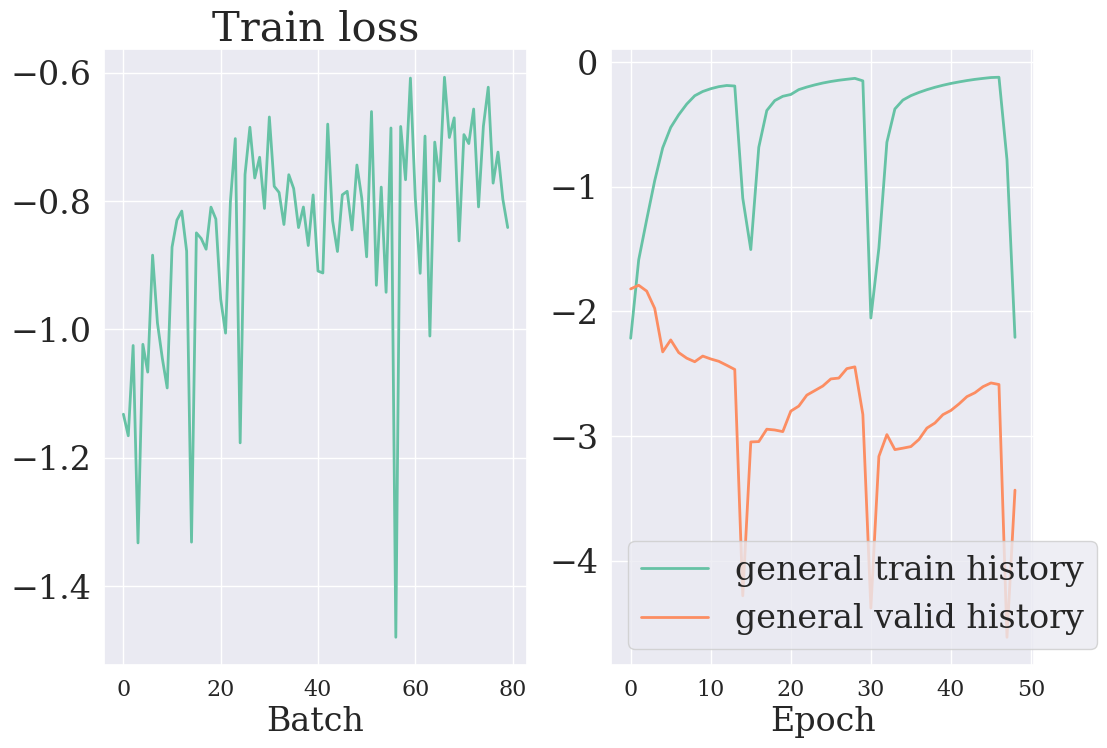

Epoch: 50 | Time: 0m 2s
	Train Loss: -0.839
	 Val. Loss: -3.140


In [14]:
model = DomainAdaptiveMLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), maximize=True)
criterion = nn.CrossEntropyLoss(reduction='mean')

train_history = []
valid_history = []

N_EPOCHS = 50

best_valid_loss = -math.inf


for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_dataloader, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss >= best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [55]:
def calculate_accuracy(y_pred, y_true):
    """ Helper function to calculate accuracy given predictions and actual labels. """
    predicted_classes = torch.argmax(y_pred, dim=1)
    correct = (predicted_classes == y_true).float()  # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def evaluate_model(model, test_loader):
    """ Evaluates the model's accuracy on the test dataset. """
    model.eval()  # Set the model to evaluation mode
    total_accuracy = 0
    total_count = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in test_loader:
            domain, inp, trg = batch
            
            output_splitted = model(domain, inp)
            trg_splitted = split_domains(domain, trg)
            
            for d in output_splitted:
                accuracy = calculate_accuracy(output_splitted[d], trg_splitted[d])
#                 print(accuracy.item(), len(output_splitted[d]))
                total_accuracy += accuracy.item() * len(output_splitted[d])
                total_count += len(output_splitted[d])

    overall_accuracy = total_accuracy / total_count if total_count > 0 else 0
    return overall_accuracy

In [56]:
# Example usage:
test_accuracy = evaluate_model(model, test_dataloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 0.634


Accuracy на домене маленьких фигур

In [57]:
test_dataset_1 = FiguresDataset(SEED, 1, DEVICE, UNITED_MEAN, UNITED_STD, X_small_tst, Y_small_tst)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_accuracy_1 = evaluate_model(model, test_dataloader_1)
print(f'Test Accuracy: {test_accuracy_1:.3f}')

Test Accuracy: 0.350


Accuracy на домене огромных фигур

In [58]:
test_dataset_2 = FiguresDataset(SEED, 2, DEVICE, UNITED_MEAN, UNITED_STD, X_large_tst, Y_large_tst)
# Умножение на 2 -- это костыль, благодаря которому поле domain_data заполняется двойками (по дефолту -- 1)
# Если оставить как есть, то для домена с большими фигурами будет вызываться модель для малых фигур
# и получим более низкое качество
test_dataset_2.domain_data *= 2
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_accuracy_2 = evaluate_model(model, test_dataloader_2)
print(f'Test Accuracy: {test_accuracy_2:.3f}')

Test Accuracy: 0.918


## Одна модель на каждый домен

### Домен малых фигур

In [19]:
train_dataset_small = FiguresDataset(SEED, 1, DEVICE, SMALL_MEAN, SMALL_STD, X_small_tr, Y_small_tr)
train_dataloader_small = DataLoader(train_dataset_small, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

val_dataset_small = FiguresDataset(SEED, 1, DEVICE, SMALL_MEAN, SMALL_STD, X_small_val, Y_small_val)
val_dataloader_small = DataLoader(val_dataset_small, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_dataset_small = FiguresDataset(SEED, 1, DEVICE, SMALL_MEAN, SMALL_STD, X_small_tst, Y_small_tst)
test_dataloader_small = DataLoader(test_dataset_small, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

$$\underset{\theta}{\mathrm{argmax}} \left( \mathcal{L}_{\text{orig}} (\mathcal{D}; \theta) - \sum_i \frac{\theta_i^2}{2\sigma^2} \right)$$

- $\mathcal{L}_{\text{orig}}$ -- это минус кросс-энтропия
- $\sigma$ своя для каждого слоя, а именно $\sigma_{\text{layer}} = \sigma / (d_{in} + d_{out})$, где $d_{in}$ и $d_{out}$ -- размерности матрицы весов линейного слоя (для bias берётся только одна размерность)

In [20]:
class MLP(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        self.sigma = nn.Parameter(torch.ones(1), requires_grad=False).to(device)

        self.model = MLPBase().to(device)
        
        self.k_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        self._init()
    
    def _init(self):
        for param in self.model.parameters():
            init_value = torch.randn_like(param, device=param.device) * self.sigma / torch.tensor(param.shape, device=param.device).sum().sqrt()
            init_value = init_value.float()
            param.data.copy_(init_value)
        
    def forward(self, domain, x):
        output_splits = {}
    
        unique_domains = torch.unique(domain)

        for d in unique_domains:
            output_splits[int(d.item())] = self.model(x[domain == d])
            
        return output_splits
    
    def calc_loss_regularizer(self):
        # Реализовано вычитаемое из формулы выше
        reg_0 = 0
        for param in self.model.parameters():
            reg_0 -= torch.sum(torch.square(param / self.sigma * torch.tensor(param.shape, device=param.device).sum().sqrt())) / 2
        
        return reg_0 / self.k_params

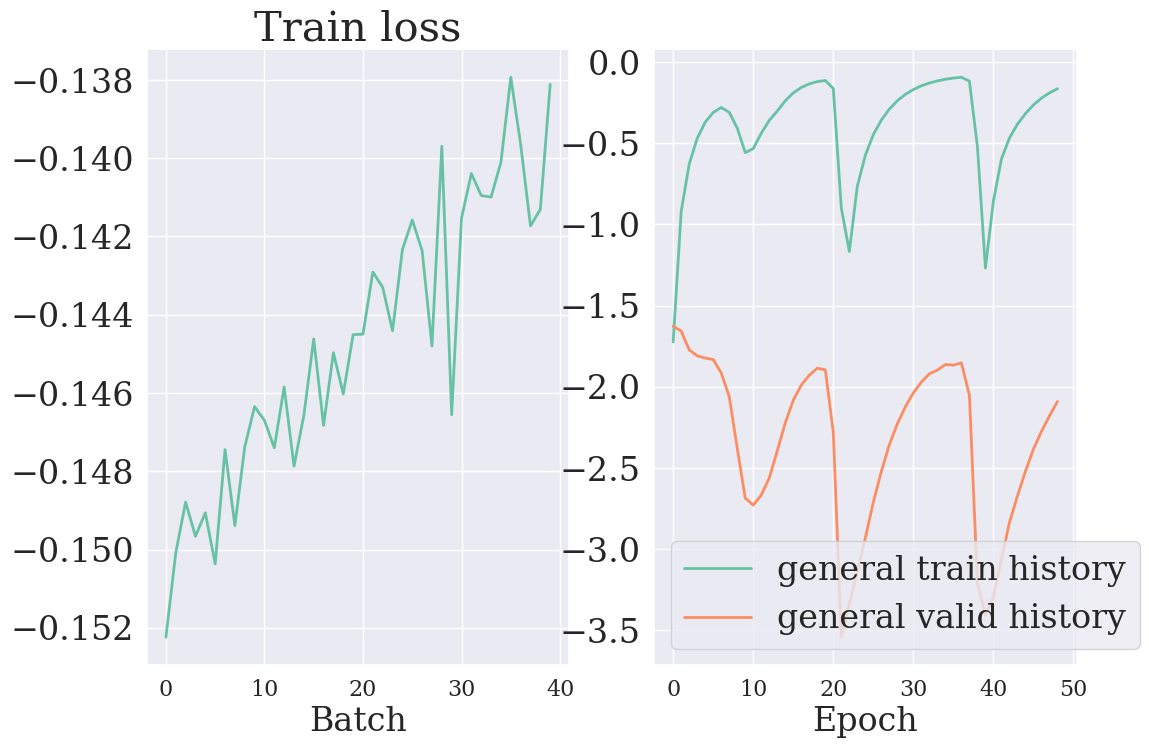

Epoch: 50 | Time: 0m 1s
	Train Loss: -0.144
	 Val. Loss: -2.024


In [21]:
model_small = MLP().to(DEVICE)
optimizer = optim.Adam(model_small.parameters(), maximize=True)
criterion = nn.CrossEntropyLoss(reduction='mean')

train_history = []
valid_history = []

N_EPOCHS = 50

best_valid_loss = -math.inf


for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model_small, train_dataloader_small, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model_small, val_dataloader_small, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss >= best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_small.state_dict(), 'best-val-small-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [22]:
# Example usage:
test_accuracy = evaluate_model(model_small, test_dataloader_small)
print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 0.384


### Домен больших фигур

In [23]:
train_dataset_large = FiguresDataset(SEED, 1, DEVICE, LARGE_MEAN, LARGE_STD, X_large_tr, Y_large_tr)
train_dataloader_large = DataLoader(train_dataset_large, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

val_dataset_large = FiguresDataset(SEED, 1, DEVICE, LARGE_MEAN, LARGE_STD, X_large_val, Y_large_val)
val_dataloader_large = DataLoader(val_dataset_large, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_dataset_large = FiguresDataset(SEED, 2, DEVICE, LARGE_MEAN, LARGE_STD, X_large_tst, Y_large_tst)
test_dataloader_large = DataLoader(test_dataset_large, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

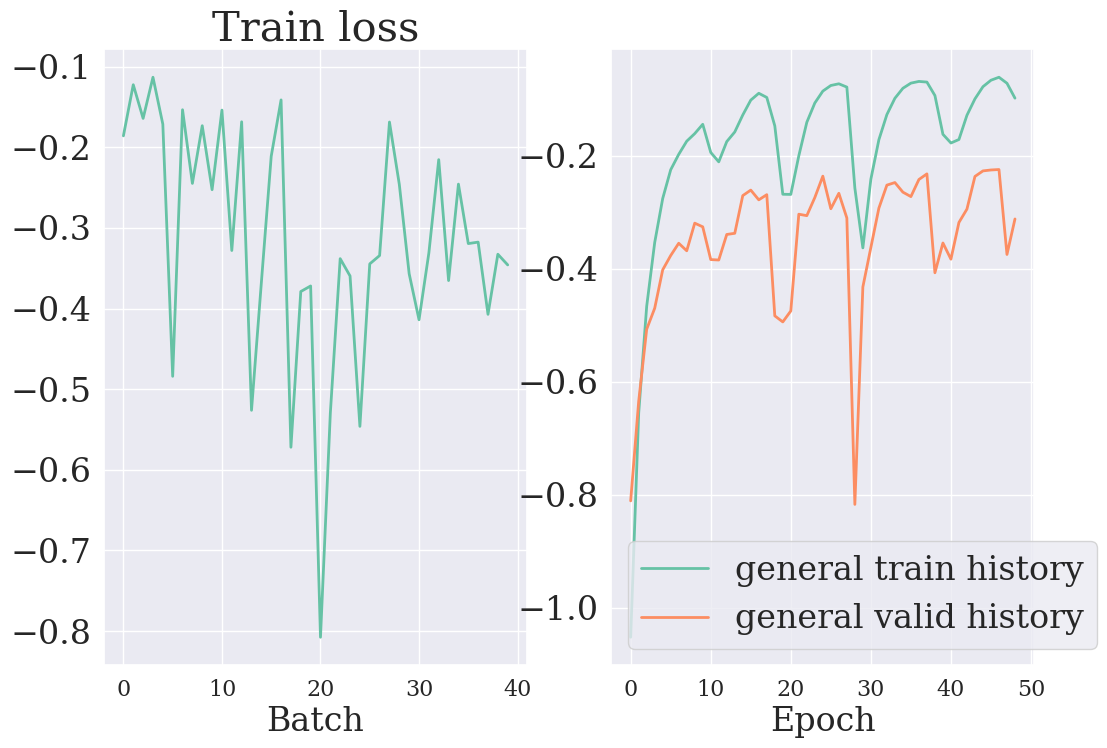

Epoch: 50 | Time: 0m 1s
	Train Loss: -0.318
	 Val. Loss: -0.506


In [25]:
model_large = MLP().to(DEVICE)
optimizer = optim.Adam(model_large.parameters(), maximize=True)
criterion = nn.CrossEntropyLoss(reduction='mean')

train_history = []
valid_history = []

N_EPOCHS = 50

best_valid_loss = -math.inf


for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model_large, train_dataloader_large, optimizer, criterion, train_history, valid_history)
    valid_loss = evaluate(model_large, val_dataloader_large, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss >= best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_large.state_dict(), 'best-val-large-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

In [26]:
# Example usage:
test_accuracy = evaluate_model(model_large, test_dataloader_large)
print(f'Test Accuracy: {test_accuracy:.3f}')

Test Accuracy: 0.849


## Вывод

*Результаты данного запуска:*

Качество разных MLP на разных доменах = (0.384, 0.849), среднее = 0.6165

Качество одной MLP на разных доменах = (0.350, 0.918), среднее = 0.634


**Таким образом, использование `domain adaptation` повысило качество прогноза на 2%**

Однако, для получения стат.значимых результатов, за рамками этого ноутбука я прогнал этот код 10 раз с различными SEED, и вот какие значения у меня получились

In [62]:
without_domain_adapt_ttl = [0.617, 0.660, 0.659, 0.636, 0.65, 0.654, 0.663, 0.658, 0.658, 0.661]
with_domain_adapt_ttl = [0.634, 0.653, 0.667, 0.636, 0.644, 0.636, 0.659, 0.636, 0.646, 0.663]


without_domain_adapt_small = [0.384, 0.412, 0.442, 0.392, 0.393, 0.413, 0.395, 0.393, 0.390, 0.413]
with_domain_adapt_small = [0.350, 0.385, 0.408, 0.402, 0.392, 0.395, 0.385, 0.382, 0.368, 0.398]


without_domain_adapt_large = [0.849, 0.907, 0.875, 0.880, 0.907, 0.895, 0.930, 0.923, 0.925, 0.908]
with_domain_adapt_large = [0.918, 0.923, 0.925, 0.870, 0.895, 0.877, 0.932, 0.890, 0.923, 0.927]

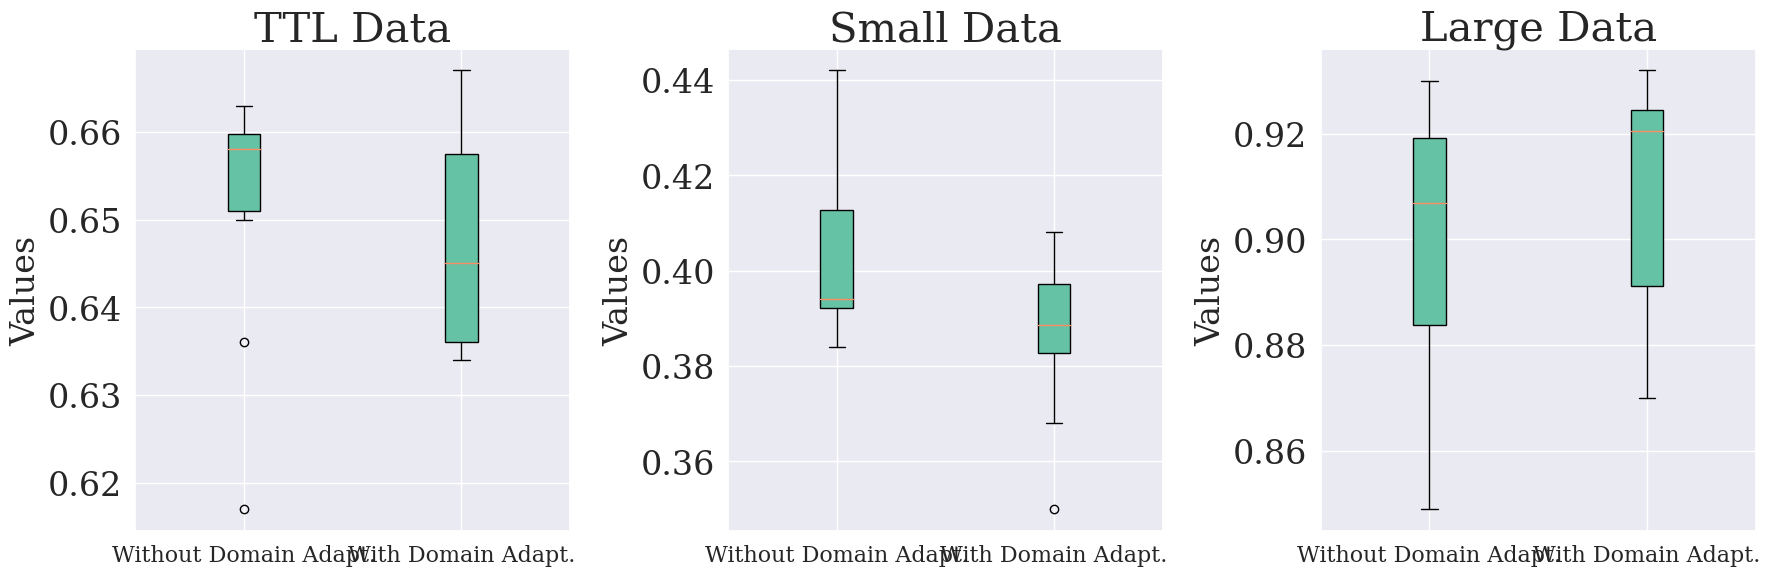

In [73]:
# Setting up the figure and axes for the subplots
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the boxplots for each dataset pair on each subplot
datasets = [
    (without_domain_adapt_ttl, with_domain_adapt_ttl),
    (without_domain_adapt_small, with_domain_adapt_small),
    (without_domain_adapt_large, with_domain_adapt_large)
]
titles = ["TTL Data", "Small Data", "Large Data"]
labels = ['Without Domain Adapt.', 'With Domain Adapt.']

for i, data_pair in enumerate(datasets):
    # Boxplot for each pair
    ax[i].boxplot(data_pair, labels=labels, notch=False, patch_artist=True)
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Values')

# Show the plot
plt.tight_layout()
plt.show()

Но при большем кол-ве запусков оказалось, что использование Domain Adaptation **не приводит к стат.значимому улучшению качества**